In [1]:
""" Web Parsing and Time-Series Plotting
    This is basic example of scraping information off of a web page
    (using Python, requests, and BeautifulSoup),
    and basic plot-making
    (using Python and matplotlib)
    
    The data we are going to use is taken from GoodReads
    (*the* book review website) and we are going to be looking at
    the Discworld series, by Terry Pratchett.
    
    People often ask me where they should start with the Discworld
    series. There are 41 books in the series, and that can sound
    intimidating. But, in reality, they aren't one continuous story
    line. You can jump in anywhere. Still, perhaps we can do a little
    digging and see where some optimal starting locations might be.
    
    The data in question came from this URL:
    https://www.goodreads.com/series/40650-discworld
"""
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import pandas as pd
import requests
%matplotlib inline


In [38]:
""" At this point, I grabbed the HTML from the link above.
    Just in case the Goodreads website changes formats, I have preserved
    a copy of the data I used in the attached HTML file.
    
    Below you will  find the `requests` command I originally
    used to grab the web page.
"""
"""
r = requests.get('https://www.goodreads.com/series/40650-discworld')
fout = open('goodreads_discworld.html', 'w')
fout.write(r.text)
fout.close()
"""
fin = open('goodreads_discworld.html', 'r')
html = fin.read()
fin.close()

print(len(html))  # number of characters on page (just FYI)

592372


In [39]:
def parse_discworld():
    """ Okay, time to start parsing this page and pulling
        out the data we want about each book.
        This is a big, ugly data-munging function.
        You'll frequently get these then trying to parse HTML.
        Very few websites are designed to make parsing
        scripts beautiful.
    """
    series_str = ' (Discworld, #'

    soup = BeautifulSoup(html, 'html.parser')
    books = []
    # there is a big table of all the books in the series
    book_table = soup.find('table')
    # each table row is a single book
    rows = book_table.find_all('tr')
    for row in rows:
        # only the second column has any info
        col = row.find_all('td')[1]
        # parse the book title
        title_long = col.find('span', itemprop='name').text
        if series_str not in title_long: continue
        # there are some little "#40.5" intermediate books I want to ignore
        if '.' in title_long: continue
        title = title_long.split(series_str)[0]
        # Which book in the series is this?
        series_number = int(title_long.split(series_str)[1].replace(')', ';').split(';')[0])
        # Is this book part of a sub-series of books?
        if ';' in title_long:
            subseries = title_long.split(series_str)[1].replace(')', ';').split(';')[1].strip().split(',')[0]  
            if '#' in subseries:
                subseries = subseries.split('#')[0].strip()
        else:
            subseries = ''
        # parse GoodReads user rating info
        rating_info = col.findAll(attrs={'class': "minirating"})[0].text.split('rating')
        avg_rating = float(rating_info[0].split('stars ')[1].split(' avg')[0])
        num_ratings = int(rating_info[1].replace('—', '').replace(',', '').strip())
        # What year was the book published?
        yr = int(col.findAll(attrs={'class': "greyText smallText uitext"})[0].text.split('\n')[4].strip())
        books.append({'number': series_number, 'title': title, 'yr': yr,
                      'avg_rating': avg_rating, 'num_ratings': num_ratings,
                      'subseries': subseries})

    return books
    
books = parse_discworld()

In [40]:
""" Here I a just spot-checking the validity of my web-scraping.
    I build my function piece-by-piece, using these spot checks
    for validity.
"""

print(len(books))
print(books[0])
print(books[40])

41
{'num_ratings': 172994, 'title': 'The Color of Magic', 'subseries': 'Rincewind', 'avg_rating': 3.94, 'yr': 1983, 'number': 1}
{'num_ratings': 4465, 'title': "The Shepherd's Crown", 'subseries': 'Tiffany Aching', 'avg_rating': 4.36, 'yr': 2015, 'number': 41}


In [44]:
# Which books got the highest goodreads user ratings?
books = pd.DataFrame(books)
books.sort(['avg_rating'], ascending=0)[:10]

,avg_rating,num_ratings,number,subseries,title,yr
28,4.45,68053,29,City Watch,Night Watch,2002
40,4.36,4465,41,Tiffany Aching,The Shepherd's Crown,2015
32,4.34,68581,33,Moist von Lipwig,Going Postal,2004
37,4.33,28420,38,Tiffany Aching,I Shall Wear Midnight,2010
14,4.32,48366,15,City Watch,Men at Arms,1993
7,4.29,92697,8,City Watch,Guards! Guards!,1989
31,4.27,40620,32,Tiffany Aching,A Hat Full of Sky,2004
33,4.26,41000,34,City Watch,Thud!,2005
10,4.26,50977,11,Death,Reaper Man,1991
12,4.25,67956,13,,Small Gods,1992


In [45]:
# Which books have been read more times?
books.sort(['num_ratings'], ascending=0)[:10]

,avg_rating,num_ratings,number,subseries,title,yr
0,3.94,172994,1,Rincewind,The Color of Magic,1983
3,4.18,106431,4,Death,Mort,1987
7,4.29,92697,8,City Watch,Guards! Guards!,1989
2,3.96,79676,3,Witches,Equal Rites,1987
1,3.91,69990,2,Rincewind,The Light Fantastic,1986
32,4.34,68581,33,Moist von Lipwig,Going Postal,2004
28,4.45,68053,29,City Watch,Night Watch,2002
12,4.25,67956,13,,Small Gods,1992
29,4.23,57566,30,Tiffany Aching,The Wee Free Men,2003
5,4.09,55853,6,Witches,Wyrd Sisters,1988


In [46]:
# What books are the most popular?
rats = set(books.sort(['num_ratings'], ascending=0)[:11]['title'])
vals = (set(books.sort(['avg_rating'], ascending=0)[:11]['title']))
popular = [b for b in rats if b in vals]
print(popular)

['Night Watch', 'Reaper Man', 'Guards! Guards!', 'Small Gods', 'Going Postal']


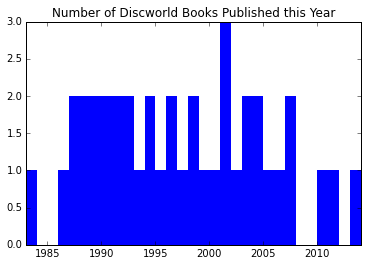

In [47]:
""" And now for a little time-series plotting.
    Where were the books in this series published?
"""
books_year = []
yrs = range(1983, 2016)
for yr in yrs:
    books_year.append(len(books[books['yr'] == yr]))
plt.bar(yrs, books_year, color='b', edgecolor='none', width=1.0)
plt.title('Number of Discworld Books Published this Year')
plt.xlim(1983, 2014)
plt.show()

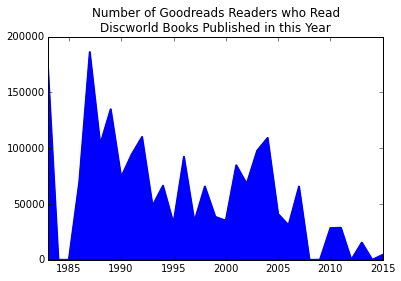

In [48]:
""" Now let's see how many people read the books that
    were published in each year.
"""
ratings_year = []
for yr in yrs:
    ratings_year.append(sum(books[books['yr'] == yr]['num_ratings']))
plt.plot(yrs, ratings_year, linewidth=2)
plt.xlim(1983, 2015)
plt.fill_between(yrs, ratings_year, 0)
plt.title('Number of Goodreads Readers who Read\nDiscworld Books Published in this Year')
plt.show()

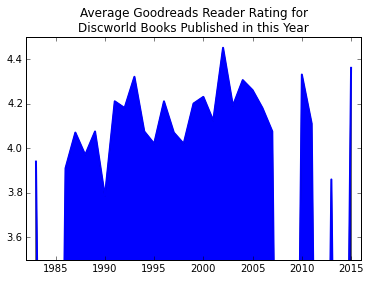

In [49]:
# avg rating for each publication year
avg_ra_year = []
i = 0
for yr in yrs:
    if books_year[i] > 0:
        avg_ra_year.append(sum(books[books['yr'] == yr]['avg_rating']) / len(books[books['yr'] == yr]))
    else:
        avg_ra_year.append(0)
    i += 1
plt.plot(yrs, avg_ra_year, linewidth=2)
plt.xlim(1982, 2016)
plt.ylim(3.5, 4.5)
plt.fill_between(yrs, avg_ra_year, 0)
plt.title('Average Goodreads Reader Rating for\nDiscworld Books Published in this Year')
plt.show()

In [50]:
series_books = books[books.subseries != '']

In [51]:
series_books.groupby('subseries').count()['number'].order()

subseries
Moist von Lipwig    1
Death               5
Tiffany Aching      5
Witches             6
City Watch          8
Rincewind           8
Name: number, dtype: int64

In [52]:
series_books.groupby('subseries').mean()['avg_rating'].order()


subseries
Rincewind           3.95000
Witches             4.07000
Death               4.16800
City Watch          4.24125
Tiffany Aching      4.27400
Moist von Lipwig    4.34000
Name: avg_rating, dtype: float64

In [53]:
# List the books in each top series
set_books = books[books['subseries'].isin(['Death', 'City Watch', 'Tiffany Aching'])]
set_books[['title', 'subseries', 'number']].sort('subseries')

,title,subseries,number
7,Guards! Guards!,City Watch,8
14,Men at Arms,City Watch,15
18,Feet of Clay,City Watch,19
20,Jingo,City Watch,21
23,The Fifth Elephant,City Watch,24
28,Night Watch,City Watch,29
33,Thud!,City Watch,34
38,Snuff,City Watch,39
3,Mort,Death,4
10,Reaper Man,Death,11
